In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor


In [11]:
import warnings
warnings.filterwarnings("ignore", module="pandas.io.formats.format")


In [12]:
# pulling the parquets from s3 and loading into pandas dataframes

# Use a raw string or forward slashes to avoid Windows backslash escapes
df = pd.read_parquet(r"C:\Users\GIGABYTE\Documents\ml\mlops\data\clean\clean.parquet")
df.head()

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,hour
0,1,AdO3,AdO3-4,Private,NaN,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
1,2,AdO3,AdO3-4,Private,NaN,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,2018-12-21 10:00:00
2,3,AdO3,AdO3-4,Private,NaN,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,2018-12-21 11:00:00
3,4,AdO3,AdO3-2,Private,NaN,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,2018-12-22 16:00:00
4,5,AdO3,AdO3-2,Private,NaN,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,2018-12-24 22:00:00


In [13]:
testing = df[df['duration_hours'] > 24]
testing.sample(5)

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,hour
4536,4537,AdO1,AdO1-4,Private,NaN,2019-12-02 17:45:00,17,2019-12-05 19:00:00,19,5.35,73.247500,Dec,Monday,late afternoon (15-18),More than 18 hours,2019-12-02 17:00:00
5729,5730,Ris,Ris-1,Private,NaN,2020-01-04 14:23:00,14,2020-01-06 12:06:00,12,6.00,45.719167,Jan,Saturday,early afternoon (12-15),More than 18 hours,2020-01-04 14:00:00
694,695,AsO2,AsO2-1,Private,NaN,2019-04-12 18:14:00,18,2019-04-14 10:27:00,10,13.87,40.229167,Apr,Friday,early evening (18-21),More than 18 hours,2019-04-12 18:00:00
5233,5234,AsO8,AsO8-3,Private,NaN,2019-12-20 16:43:00,16,2019-12-22 10:31:00,10,17.04,41.809167,Dec,Friday,late afternoon (15-18),More than 18 hours,2019-12-20 16:00:00
3082,3083,MS1,MS1-1,Private,NaN,2019-10-22 20:09:00,20,2019-10-24 12:54:00,12,1.83,40.747222,Oct,Tuesday,early evening (18-21),More than 18 hours,2019-10-22 20:00:00


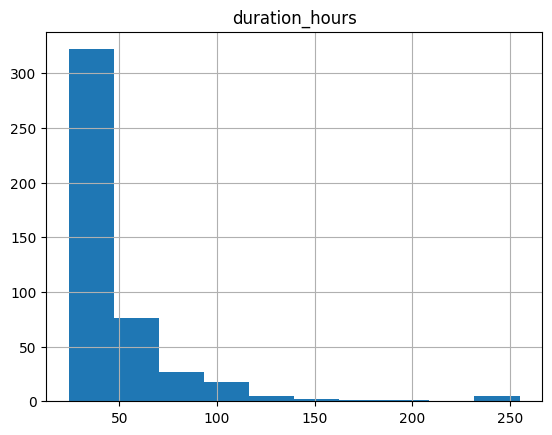

In [14]:
testing.hist(column='duration_hours')
plt.show()

In [15]:
hourly_total = (df.groupby('hour', as_index=True).agg(total_kwh=('el_kwh','sum'),n_sessions=('session_id','count'),avg_kwh=('el_kwh','mean')).sort_index())
hourly_total['n_sessions_lag1']  = hourly_total['n_sessions'].shift(1)
hourly_total['avg_kwh_lag1']    = hourly_total['avg_kwh'].shift(1)
hourly_total = hourly_total.drop(columns=['n_sessions','avg_kwh'])
print(hourly_total)

                     total_kwh  n_sessions_lag1  avg_kwh_lag1
hour                                                         
2018-12-21 10:00:00       1.17              NaN           NaN
2018-12-21 11:00:00      29.87              2.0      0.585000
2018-12-22 16:00:00      15.56              1.0     29.870000
2018-12-24 22:00:00       3.62              1.0     15.560000
2018-12-24 23:00:00      16.14              1.0      3.620000
...                        ...              ...           ...
2020-01-31 16:00:00      12.96              3.0      6.630000
2020-01-31 17:00:00      24.91              3.0      4.320000
2020-01-31 18:00:00       9.10              3.0      8.303333
2020-01-31 19:00:00       6.59              1.0      9.100000
2020-01-31 20:00:00      20.14              2.0      3.295000

[3340 rows x 3 columns]


In [16]:
hourly_total.head()

,total_kwh,n_sessions_lag1,avg_kwh_lag1
hour,,,
2018-12-21 10:00:00,1.17,NaN,NaN
2018-12-21 11:00:00,29.87,2.0,0.585
2018-12-22 16:00:00,15.56,1.0,29.870
2018-12-24 22:00:00,3.62,1.0,15.560
2018-12-24 23:00:00,16.14,1.0,3.620


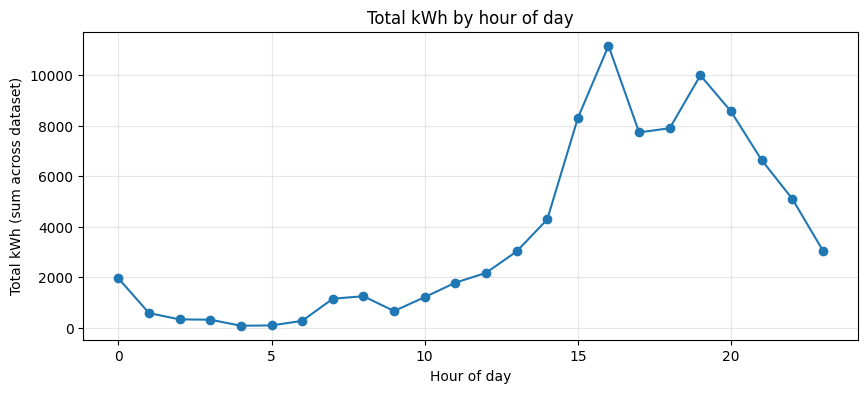

In [17]:
hourly_by_daypart = df.groupby('start_plugin_hour').el_kwh.sum().reindex(range(24))
hourly_mean_by_daypart = df.groupby('start_plugin_hour').el_kwh.mean().reindex(range(24))

plt.figure(figsize=(10,4))
plt.plot(hourly_by_daypart.index, hourly_by_daypart.values, marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh (sum across dataset)')
plt.title('Total kWh by hour of day')
plt.grid(alpha=0.3)
plt.show()

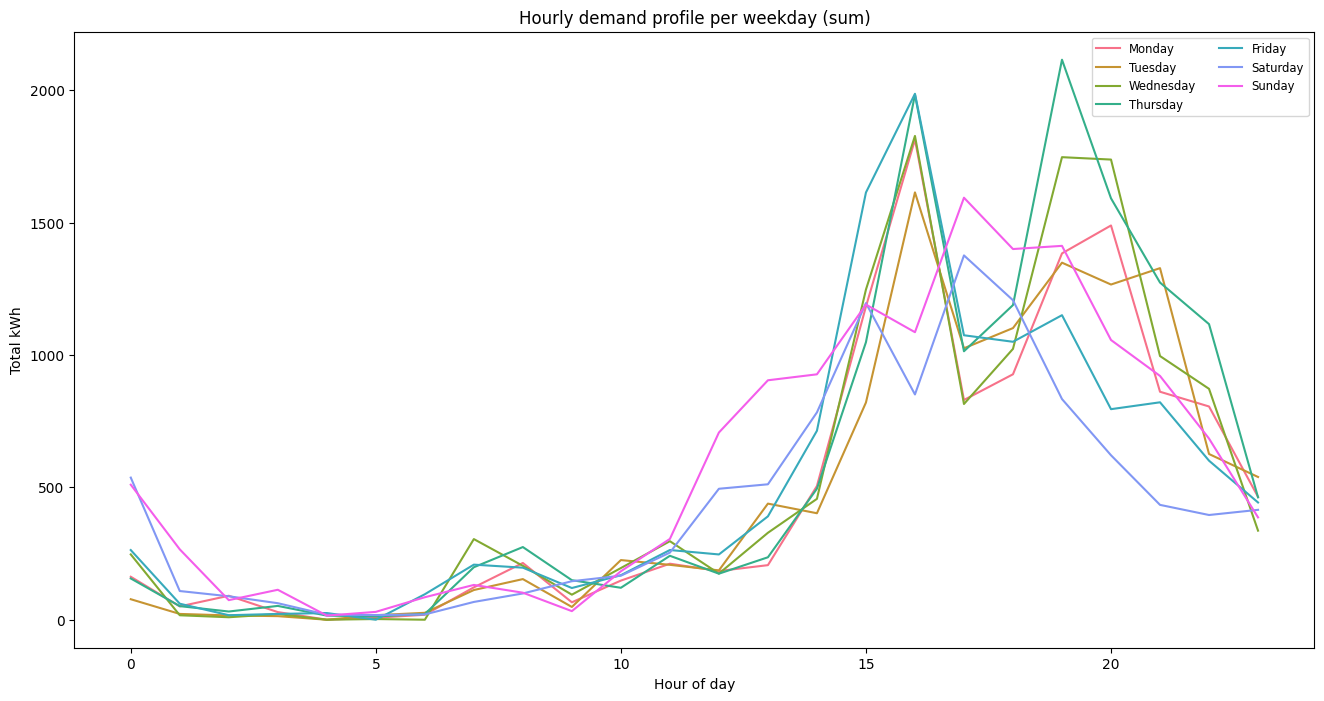

In [18]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mean_by_weekday_hour = df.groupby(['weekdays_plugin','start_plugin_hour'], observed=False).el_kwh.sum().unstack(0).reindex(columns=weekday_order)
plt.figure(figsize=(16,8))
colors = sns.color_palette("husl", len(weekday_order))
for color, wd in enumerate(weekday_order):
    plt.plot(mean_by_weekday_hour.index, mean_by_weekday_hour[wd], label=wd, color=colors[color])
plt.legend(ncol=2, fontsize='small')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh')
plt.title('Hourly demand profile per weekday (sum)')
plt.show()

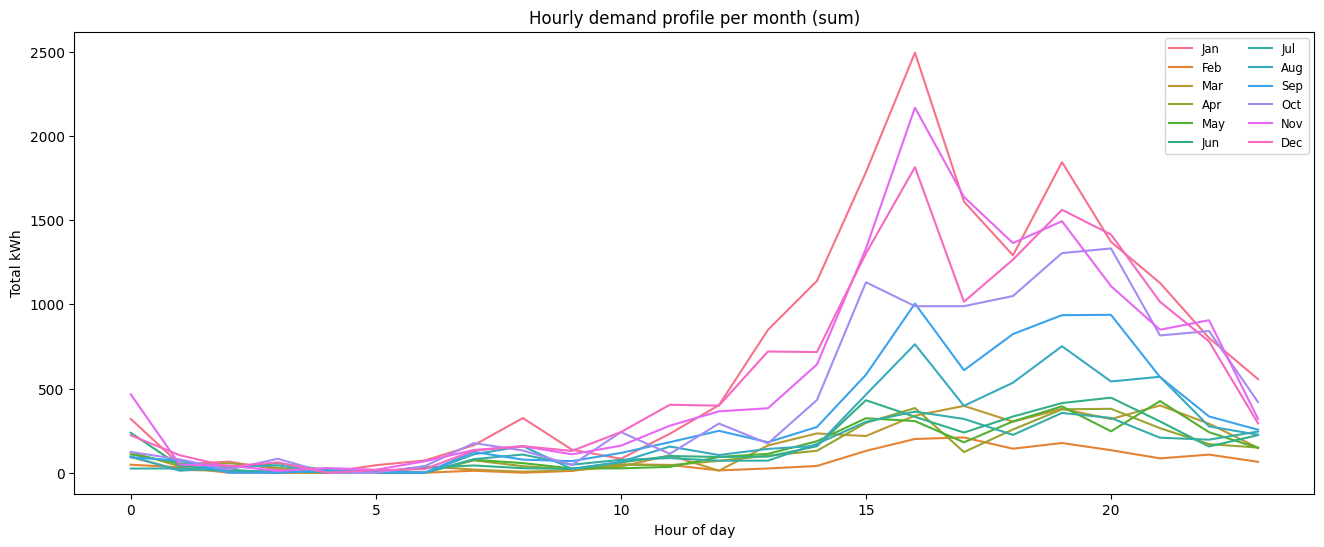

In [19]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mean_by_month = df.groupby(['month_plugin','start_plugin_hour'], observed=False).el_kwh.sum().unstack(0).reindex(columns=month)
plt.figure(figsize=(16,6))
colors = sns.color_palette("husl", len(month))
for color,m in enumerate(month):
    plt.plot(mean_by_month.index, mean_by_month[m], label=m, color=colors[color])
plt.legend(ncol=2, fontsize='small')
plt.xlabel('Hour of day')
plt.ylabel('Total kWh')
plt.title('Hourly demand profile per month (sum)')
plt.show()

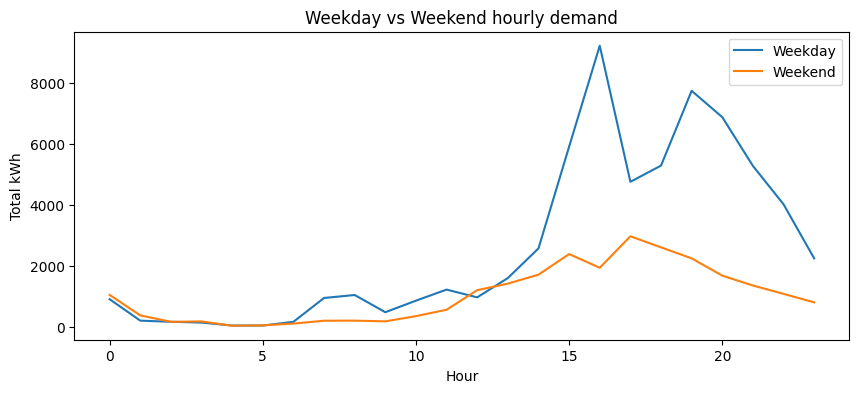

In [20]:
# mark weekend
df['is_weekend'] = df['weekdays_plugin'].isin(['Saturday','Sunday'])
agg_weekend = df.groupby(['is_weekend','start_plugin_hour']).el_kwh.sum().unstack(0)

plt.figure(figsize=(10,4))
plt.plot(agg_weekend.index, agg_weekend[False], label='Weekday')
plt.plot(agg_weekend.index, agg_weekend[True], label='Weekend')
plt.xlabel('Hour')
plt.ylabel('Total kWh')
plt.title('Weekday vs Weekend hourly demand')
plt.legend()
plt.show()


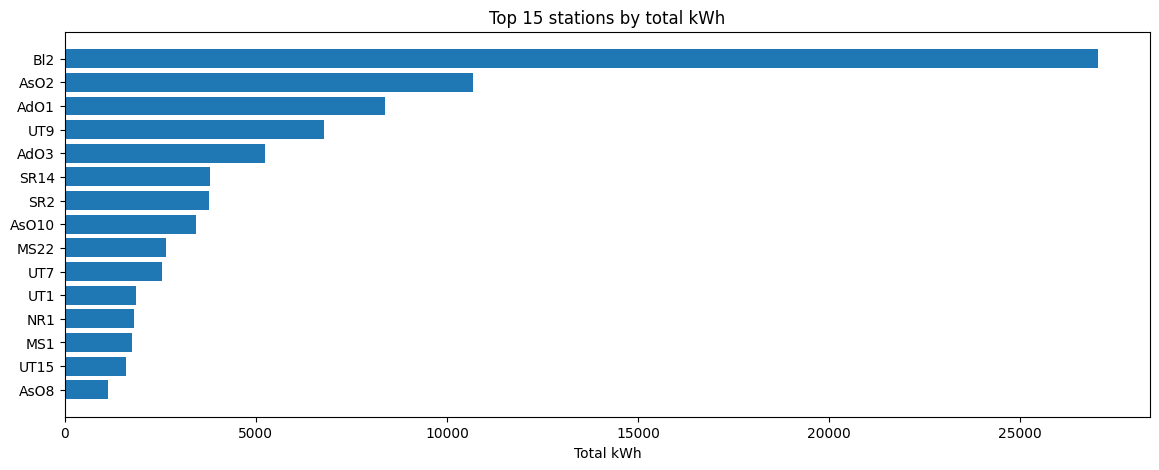

In [21]:
agg_stations = df.groupby('garage_id').agg(total_kwh=('el_kwh','sum'),
                                           n_sessions=('session_id','count'),
                                           avg_kwh=('el_kwh','mean')).sort_values(by='total_kwh', ascending=False)
top = agg_stations.head(15)

plt.figure(figsize=(14,5))
plt.barh(top.index[::-1], top['total_kwh'][::-1])
plt.xlabel('Total kWh')
plt.title('Top 15 stations by total kWh')
plt.show()

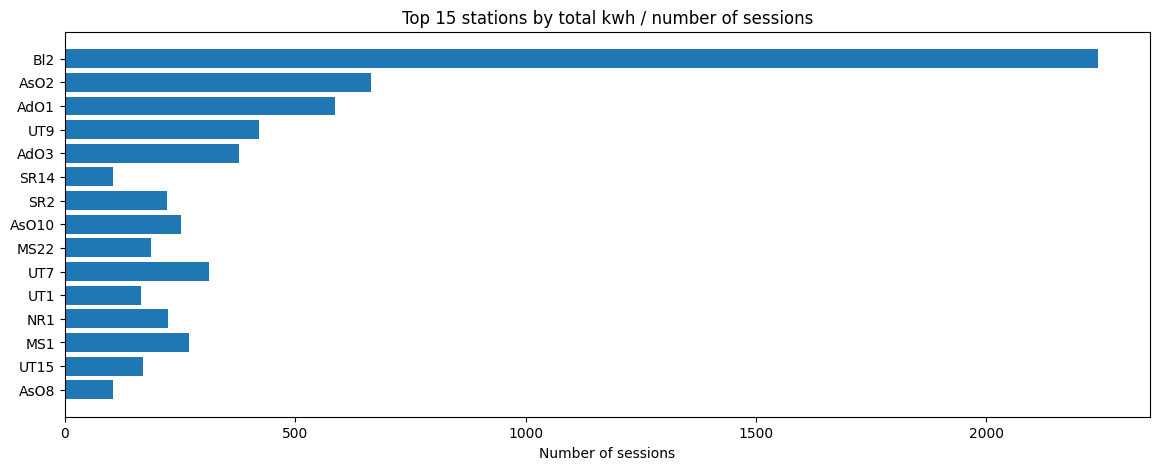

In [22]:

plt.figure(figsize=(14,5))
plt.barh(top.index[::-1], top['n_sessions'][::-1])
plt.xlabel('Number of sessions')
plt.title('Top 15 stations by total kwh / number of sessions')
plt.show()

In [23]:
# outlier detection using IQR
q1 = agg_stations['total_kwh'].quantile(0.25)
q3 = agg_stations['total_kwh'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5*iqr
outliers = agg_stations[agg_stations['total_kwh'] > upper_bound]
print(f'Outlier stations based on total kWh: \n {outliers}')

Outlier stations based on total kWh: 
            total_kwh  n_sessions    avg_kwh
garage_id                                  
Bl2         27046.92        2243  12.058368
AsO2        10672.16         665  16.048361
AdO1         8372.83         586  14.288106


In [24]:
hourly_total['hour_of_day'] = hourly_total.index.hour
hourly_total['day_of_week'] = hourly_total.index.dayofweek
hourly_total['month'] = hourly_total.index.month
hourly_total.head()

,total_kwh,n_sessions_lag1,avg_kwh_lag1,hour_of_day,day_of_week,month
hour,,,,,,
2018-12-21 10:00:00,1.17,NaN,NaN,10,4,12
2018-12-21 11:00:00,29.87,2.0,0.585,11,4,12
2018-12-22 16:00:00,15.56,1.0,29.870,16,5,12
2018-12-24 22:00:00,3.62,1.0,15.560,22,0,12
2018-12-24 23:00:00,16.14,1.0,3.620,23,0,12


In [25]:
#cyclical encoding 
hourly_total['hour_sin'] = np.sin(2*np.pi*hourly_total['hour_of_day']/24)
hourly_total['hour_cos'] = np.cos(2*np.pi*hourly_total['hour_of_day']/24)
hourly_total['dow_sin'] = np.sin(2*np.pi*hourly_total['day_of_week']/7)
hourly_total['dow_cos'] = np.cos(2*np.pi*hourly_total['day_of_week']/7)
hourly_total['month_sin'] = np.sin(2*np.pi*(hourly_total['month']-1)/12)
hourly_total['month_cos'] = np.cos(2*np.pi*(hourly_total['month']-1)/12)
hourly_total.head()

,total_kwh,n_sessions_lag1,avg_kwh_lag1,hour_of_day,day_of_week,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
hour,,,,,,,,,,,,
2018-12-21 10:00:00,1.17,NaN,NaN,10,4,12,0.500000,-0.866025,-0.433884,-0.900969,-0.5,0.866025
2018-12-21 11:00:00,29.87,2.0,0.585,11,4,12,0.258819,-0.965926,-0.433884,-0.900969,-0.5,0.866025
2018-12-22 16:00:00,15.56,1.0,29.870,16,5,12,-0.866025,-0.500000,-0.974928,-0.222521,-0.5,0.866025
2018-12-24 22:00:00,3.62,1.0,15.560,22,0,12,-0.500000,0.866025,0.000000,1.000000,-0.5,0.866025
2018-12-24 23:00:00,16.14,1.0,3.620,23,0,12,-0.258819,0.965926,0.000000,1.000000,-0.5,0.866025


In [26]:
# add lags
hourly_total['lag_1']   = hourly_total['total_kwh'].shift(1)
hourly_total['lag_24']  = hourly_total['total_kwh'].shift(24)
hourly_total['lag_168'] = hourly_total['total_kwh'].shift(168)

# differences t-1 - t-2 (preventing data leakage)
hourly_total['diff_lag1'] = hourly_total['total_kwh'].shift(1) - hourly_total['total_kwh'].shift(2)
hourly_total.head()


,total_kwh,n_sessions_lag1,avg_kwh_lag1,hour_of_day,day_of_week,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,lag_1,lag_24,lag_168,diff_lag1
hour,,,,,,,,,,,,,,,,
2018-12-21 10:00:00,1.17,NaN,NaN,10,4,12,0.500000,-0.866025,-0.433884,-0.900969,-0.5,0.866025,NaN,NaN,NaN,NaN
2018-12-21 11:00:00,29.87,2.0,0.585,11,4,12,0.258819,-0.965926,-0.433884,-0.900969,-0.5,0.866025,1.17,NaN,NaN,NaN
2018-12-22 16:00:00,15.56,1.0,29.870,16,5,12,-0.866025,-0.500000,-0.974928,-0.222521,-0.5,0.866025,29.87,NaN,NaN,28.70
2018-12-24 22:00:00,3.62,1.0,15.560,22,0,12,-0.500000,0.866025,0.000000,1.000000,-0.5,0.866025,15.56,NaN,NaN,-14.31
2018-12-24 23:00:00,16.14,1.0,3.620,23,0,12,-0.258819,0.965926,0.000000,1.000000,-0.5,0.866025,3.62,NaN,NaN,-11.94


In [27]:
# rolling stats only from past values
hourly_total['roll_mean_3h']  = hourly_total['total_kwh'].shift(1).rolling(window=3).mean()
hourly_total['roll_mean_6h']  = hourly_total['total_kwh'].shift(1).rolling(window=6).mean()
hourly_total['roll_mean_24h'] = hourly_total['total_kwh'].shift(1).rolling(window=24).mean()
hourly_total['roll_std_24h']  = hourly_total['total_kwh'].shift(1).rolling(window=24).std()
hourly_total['roll_mean_168h'] = hourly_total['total_kwh'].shift(1).rolling(window=168).mean()
hourly_total.sample(5)

,total_kwh,n_sessions_lag1,avg_kwh_lag1,hour_of_day,day_of_week,month,hour_sin,hour_cos,dow_sin,dow_cos,...,month_cos,lag_1,lag_24,lag_168,diff_lag1,roll_mean_3h,roll_mean_6h,roll_mean_24h,roll_std_24h,roll_mean_168h
hour,,,,,,,,,,,,,,,,,,,,,
2019-08-24 15:00:00,6.82,1.0,15.740,15,5,8,-0.707107,-0.707107,-0.974928,-0.222521,...,-0.866025,15.74,5.04,18.66,13.11,14.026667,11.540000,18.561250,13.568408,21.853155
2019-05-25 11:00:00,10.46,2.0,7.965,11,5,5,0.258819,-0.965926,-0.974928,-0.222521,...,-0.500000,15.93,17.15,5.99,1.41,13.766667,19.888333,22.031667,15.239198,16.871964
2019-02-27 11:00:00,6.00,1.0,7.220,11,2,2,0.258819,-0.965926,0.974928,-0.222521,...,0.866025,7.22,18.48,14.40,-8.01,9.556667,10.163333,13.857500,7.658798,13.847679
2019-11-02 13:00:00,7.48,1.0,4.740,13,5,11,-0.258819,-0.965926,-0.974928,-0.222521,...,0.500000,4.74,20.44,9.01,-4.67,6.800000,17.073333,31.953750,28.363438,31.109940
2020-01-21 23:00:00,37.34,2.0,3.915,23,1,1,-0.258819,0.965926,0.781831,0.623490,...,1.000000,7.83,24.15,4.61,-27.86,38.573333,49.606667,39.178333,26.820241,38.765357


In [28]:
# calculating mean total_kwh for each (hour_of_day, day_of_week) combination using only past data
expanding_means = (
    hourly_total
    .groupby(['hour_of_day', 'day_of_week'])['total_kwh']
    .apply(lambda x: x.shift(1).expanding().mean())
)
expanding_means = expanding_means.reset_index(level=[0, 1], drop=True)
hourly_total['hour_dow_mean'] = expanding_means
hourly_total[(hourly_total['hour_of_day'] == 10) & (hourly_total['day_of_week'] == 4)].head()

,total_kwh,n_sessions_lag1,avg_kwh_lag1,hour_of_day,day_of_week,month,hour_sin,hour_cos,dow_sin,dow_cos,...,lag_1,lag_24,lag_168,diff_lag1,roll_mean_3h,roll_mean_6h,roll_mean_24h,roll_std_24h,roll_mean_168h,hour_dow_mean
hour,,,,,,,,,,,,,,,,,,,,,
2018-12-21 10:00:00,1.17,NaN,NaN,10,4,12,0.5,-0.866025,-0.433884,-0.900969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-22 10:00:00,18.48,1.0,7.51,10,4,2,0.5,-0.866025,-0.433884,-0.900969,...,7.51,22.73,14.64,-4.27,8.063333,7.456667,12.707500,6.794044,13.375655,1.170000
2019-06-14 10:00:00,4.54,1.0,6.37,10,4,6,0.5,-0.866025,-0.433884,-0.900969,...,6.37,5.47,9.04,-7.57,11.843333,12.380000,14.056667,7.967775,17.275476,9.825000
2019-07-19 10:00:00,13.03,1.0,13.28,10,4,7,0.5,-0.866025,-0.433884,-0.900969,...,13.28,7.02,18.74,-8.91,16.256667,23.338333,18.994167,14.609340,19.179940,8.063333
2019-07-26 10:00:00,20.89,1.0,1.21,10,4,7,0.5,-0.866025,-0.433884,-0.900969,...,1.21,93.82,19.68,-10.21,14.460000,14.725000,21.080417,20.239558,18.884940,9.305000


In [29]:
hourly_total['is_weekend'] = hourly_total.index.dayofweek.isin([5,6]).astype(int)

In [30]:
hourly_total.columns

Index(['total_kwh', 'n_sessions_lag1', 'avg_kwh_lag1', 'hour_of_day',
       'day_of_week', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
       'month_sin', 'month_cos', 'lag_1', 'lag_24', 'lag_168', 'diff_lag1',
       'roll_mean_3h', 'roll_mean_6h', 'roll_mean_24h', 'roll_std_24h',
       'roll_mean_168h', 'hour_dow_mean', 'is_weekend'],
      dtype='object')

In [39]:
hourly_total.dtypes

total_kwh          float64
n_sessions_lag1    float64
avg_kwh_lag1       float64
hour_of_day          int32
day_of_week          int32
month                int32
hour_sin           float64
hour_cos           float64
dow_sin            float64
dow_cos            float64
month_sin          float64
month_cos          float64
lag_1              float64
lag_24             float64
lag_168            float64
diff_lag1          float64
roll_mean_3h       float64
roll_mean_6h       float64
roll_mean_24h      float64
roll_std_24h       float64
roll_mean_168h     float64
hour_dow_mean      float64
is_weekend           int64
dtype: object

In [31]:
ht = hourly_total.dropna().copy()
ht.shape

(3098, 23)

In [32]:
x = ht[['n_sessions_lag1', 'avg_kwh_lag1', 'hour_of_day',
       'day_of_week', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
       'month_sin', 'month_cos', 'lag_1', 'lag_24', 'lag_168', 'diff_lag1',
       'roll_mean_3h', 'roll_mean_6h', 'roll_mean_24h', 'roll_std_24h',
       'roll_mean_168h', 'hour_dow_mean', 'is_weekend']]
y = ht['total_kwh']
split_date = ht.index[-24*30]
x_train = x[ht.index < split_date]
x_test = x[ht.index >= split_date]
y_train = y[ht.index < split_date]
y_test = y[ht.index >= split_date]

print( f' training shape : {x_train.shape} /  testing shape {x_test.shape}')

split_date2 = ht.index[24*30]
x_train2 = x[ht.index >= split_date2]
x_test2 = x[ht.index < split_date2]
y_train2 = y[ht.index >= split_date2]
y_test2 = y[ht.index < split_date2]

print( f' training shape : {x_train2.shape} /  testing shape {x_test2.shape}')

 training shape : (2378, 22) /  testing shape (720, 22)
 training shape : (2378, 22) /  testing shape (720, 22)


In [33]:
lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
dt = DecisionTreeRegressor(random_state=42,max_depth=5)
xgb = XGBRegressor(n_estimators=100, verbosity=0, random_state=42, max_depth=5)
lgb = LGBMRegressor(n_estimators=2000, learning_rate=0.05, random_state=42)

lr.fit(x_train,y_train)
dt.fit(x_train,y_train)
xgb.fit(x_train,y_train)
lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)])

preds_lr = lr.predict(x_test)
preds_dt = dt.predict(x_test)
preds_xgb = xgb.predict(x_test)
preds_lgb = lgb.predict(x_test)

mae_lr = mean_absolute_error(y_test, preds_lr)
mse_lr = mean_squared_error(y_test, preds_lr)
mae_dt = mean_absolute_error(y_test, preds_dt)
mse_dt = mean_squared_error(y_test, preds_dt)
mae_xgb = mean_absolute_error(y_test, preds_xgb)
mse_xgb= mean_squared_error(y_test, preds_xgb)
mae_lgb = mean_absolute_error(y_test, preds_lgb)
mse_lgb= mean_squared_error(y_test, preds_lgb)

print(f' LR : {mae_lr} | {mse_lr}')
print(f' dt: {mae_dt} | {mse_dt}')
print(f' xgb : {mae_xgb} | {mse_xgb}')
print(f' lgb : {mae_lgb} | {mse_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2932
[LightGBM] [Info] Number of data points in the train set: 2378, number of used features: 22
[LightGBM] [Info] Start training from score 24.604041
 LR : 23.473406481563448 | 1143.5558195084823
 dt: 22.89555985709019 | 1036.8847126486096
 xgb : 25.262163061778686 | 1212.6737665477028
 lgb : 23.31335087591016 | 1136.9369947121


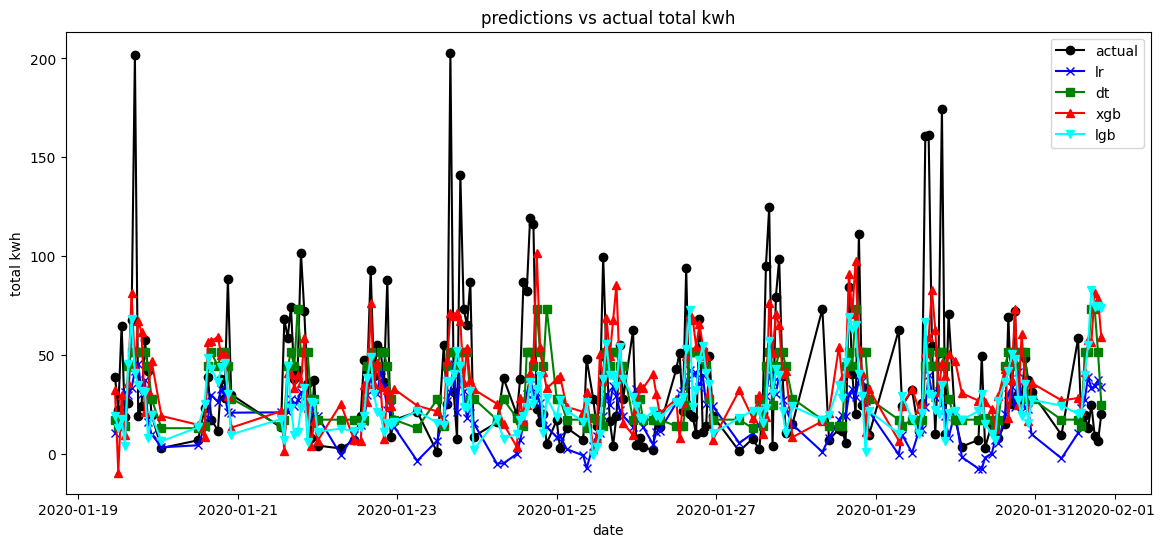

In [34]:
plt.figure(figsize=(14,6))
plt.plot(y_test[-24*7:], label="actual", marker= "o", color = "black")
plt.plot(pd.Series(preds_lr, index = y_test.index)[-24*7:], label="lr", marker= "x", color = "blue")
plt.plot(pd.Series(preds_dt, index = y_test.index)[-24*7:], label="dt", marker= "s", color = "green")
plt.plot(pd.Series(preds_xgb, index = y_test.index)[-24*7:], label="xgb", marker= "^", color = "red")
plt.plot(pd.Series(preds_lgb, index = y_test.index)[-24*7:], label="lgb", marker= "v", color = "cyan")
plt.xlabel("date")
plt.ylabel("total kwh")
plt.title("predictions vs actual total kwh")
plt.legend()
plt.show()

In [35]:
# testing with split date 2
lr.fit(x_train2,y_train2)
dt.fit(x_train2,y_train2)
xgb.fit(x_train2,y_train2)
lgb.fit(x_train2, y_train2, eval_set=[(x_test2, y_test2)])

preds_lr = lr.predict(x_test2)
preds_dt = dt.predict(x_test2)
preds_xgb = xgb.predict(x_test2)
preds_lgb = lgb.predict(x_test2)

mae_lr = mean_absolute_error(y_test2, preds_lr)
mse_lr = mean_squared_error(y_test2, preds_lr)
mae_dt = mean_absolute_error(y_test2, preds_dt)
mse_dt = mean_squared_error(y_test2, preds_dt)
mae_xgb = mean_absolute_error(y_test2, preds_xgb)
mse_xgb= mean_squared_error(y_test2, preds_xgb)
mae_lgb = mean_absolute_error(y_test2, preds_lgb)
mse_lgb= mean_squared_error(y_test2, preds_lgb)

print(f' LR : {mae_lr} | {mse_lr}')
print(f' dt: {mae_dt} | {mse_dt}')
print(f' xgb : {mae_xgb} | {mse_xgb}')
print(f' lgb : {mae_lgb} | {mse_lgb}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 2378, number of used features: 22
[LightGBM] [Info] Start training from score 30.479218
 LR : 12.17928544447323 | 216.16414250995905
 dt: 11.909055946132144 | 240.57837217721564
 xgb : 16.029476291518243 | 396.3415148936204
 lgb : 17.191403013421507 | 428.51325517694727


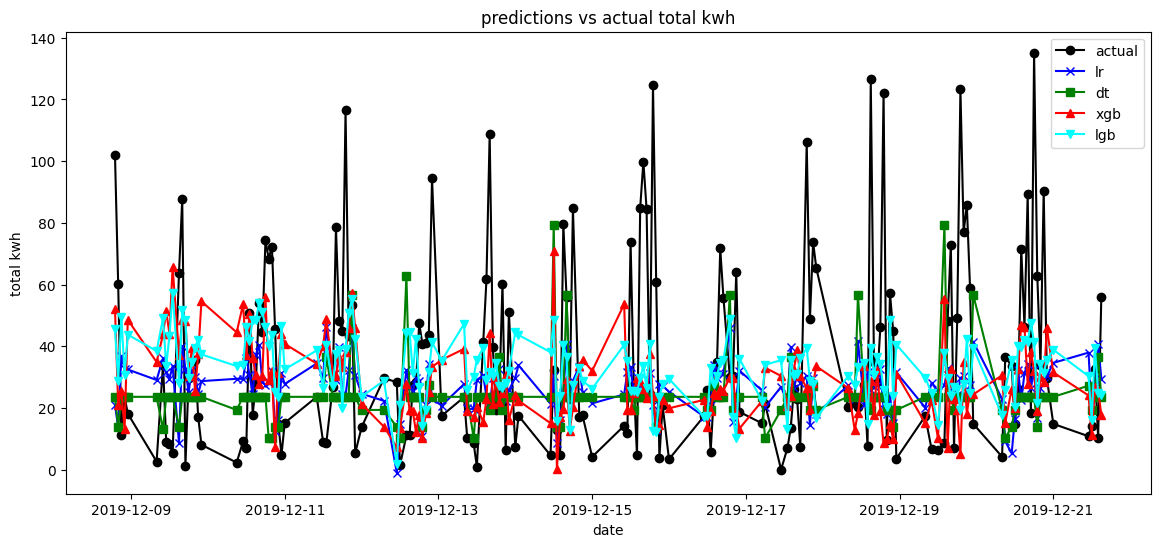

In [36]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:24*7], label="actual", marker= "o", color = "black")
plt.plot(pd.Series(preds_lr, index = y_test.index)[:24*7], label="lr", marker= "x", color = "blue")
plt.plot(pd.Series(preds_dt, index = y_test.index)[:24*7], label="dt", marker= "s", color = "green")
plt.plot(pd.Series(preds_xgb, index = y_test.index)[:24*7], label="xgb", marker= "^", color = "red")
plt.plot(pd.Series(preds_lgb, index = y_test.index)[:24*7], label="lgb", marker= "v", color = "cyan")
plt.xlabel("date")
plt.ylabel("total kwh")
plt.title("predictions vs actual total kwh")
plt.legend()
plt.show()

* model currently tracks the calm early data with good mae and mse , but for the end of the data which is volatile and have dramatic peaks and drops , the metrics drop dramatically and the models aren't able to catch those peaks : we need more context !

In [37]:
'''
import mlflow
import mlflow.sklearn  # for sklearn model logging
import os
from joblib import dump
from sklearn.metrics import root_mean_squared_error
from mlflow.models import infer_signature

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment('ev_hourly_bl')

LOCAL_MODEL_DIR = r"C:\\Users\\GIGABYTE\\Documents\\ml\\mlops\\src\\models"

models = {
  'LinearRegression': LinearRegression(),
  'DecisionTree': DecisionTreeRegressor(random_state=42, max_depth=5),
  'XGBRegressor': XGBRegressor(n_estimators=100, verbosity=0, random_state=42, max_depth=5),
  'LGBMRegressor': LGBMRegressor(n_estimators=2000, learning_rate=0.05, random_state=42)
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = root_mean_squared_error(y_test, preds)
        
        # Log configuration and metrics
        mlflow.log_param('model_type', name)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('rmse', rmse)
        
        # Log the trained model to MLflow (different ways for each library)
        signature = infer_signature(x_train, model.predict(x_train))
        if name == 'XGBRegressor':
            mlflow.xgboost.log_model(model, artifact_path="model", signature=signature)
        elif name == 'LGBMRegressor':
            mlflow.lightgbm.log_model(model, artifact_path="model", signature=signature)
        else:
            mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)

        import matplotlib.pyplot as plt
        plt.figure(figsize=(14,4))
        plt.plot(y_test.values, label="actual")
        plt.plot(preds, label=name)
        plt.legend()
        plt.title(f"Predictions vs actuals for {name}")
        plt.tight_layout()
        plot_path = os.path.join(LOCAL_MODEL_DIR, f"{name}_pred_vs_actual.png")
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.close()





        # Save model locally as joblib file
        local_path = os.path.join(LOCAL_MODEL_DIR, f"{name}.joblib")
        dump(model, local_path)
        print(f"{name} model saved locally at {local_path} and logged to MLflow.") 
'''

'\nimport mlflow\nimport mlflow.sklearn  # for sklearn model logging\nimport os\nfrom joblib import dump\nfrom sklearn.metrics import root_mean_squared_error\nfrom mlflow.models import infer_signature\n\nmlflow.set_tracking_uri("http://localhost:5000")\nmlflow.set_experiment(\'ev_hourly_bl\')\n\nLOCAL_MODEL_DIR = r"C:\\Users\\GIGABYTE\\Documents\\ml\\mlops\\src\\models"\n\nmodels = {\n  \'LinearRegression\': LinearRegression(),\n  \'DecisionTree\': DecisionTreeRegressor(random_state=42, max_depth=5),\n  \'XGBRegressor\': XGBRegressor(n_estimators=100, verbosity=0, random_state=42, max_depth=5),\n  \'LGBMRegressor\': LGBMRegressor(n_estimators=2000, learning_rate=0.05, random_state=42)\n}\n\nfor name, model in models.items():\n    with mlflow.start_run(run_name=name):\n        model.fit(x_train, y_train)\n        preds = model.predict(x_test)\n        mae = mean_absolute_error(y_test, preds)\n        rmse = root_mean_squared_error(y_test, preds)\n\n        # Log configuration and metric

In [38]:

'''import boto3
from pathlib import Path

local_processed_dir = "C:/Users/GIGABYTE/Documents/ml/mlops/data/processed"
local_file_path = f"{local_processed_dir}/fe.parquet"
s3_bucket = "ev-data"
s3_key = "processed/fe.parquet"

# Create directory if it doesn't exist
Path(local_processed_dir).mkdir(parents=True, exist_ok=True)

# Save locally
ht.to_parquet(local_file_path, 
                     engine='pyarrow', 
                     compression='snappy',
                     index=False)
print(f"fe saved locally: {local_file_path}")

# Uploading to S3
s3 = boto3.client('s3', 
                 endpoint_url="http://localhost:4566",
                 aws_access_key_id="test", 
                 aws_secret_access_key="test")

s3.upload_file(local_file_path, s3_bucket, s3_key)
print(f"fe uploaded to S3: s3://{s3_bucket}/{s3_key}")'''

'import boto3\nfrom pathlib import Path\n\nlocal_processed_dir = "C:/Users/GIGABYTE/Documents/ml/mlops/data/processed"\nlocal_file_path = f"{local_processed_dir}/fe.parquet"\ns3_bucket = "ev-data"\ns3_key = "processed/fe.parquet"\n\n# Create directory if it doesn\'t exist\nPath(local_processed_dir).mkdir(parents=True, exist_ok=True)\n\n# Save locally\nht.to_parquet(local_file_path, \n                     engine=\'pyarrow\', \n                     compression=\'snappy\',\n                     index=False)\nprint(f"fe saved locally: {local_file_path}")\n\n# Uploading to S3\ns3 = boto3.client(\'s3\', \n                 endpoint_url="http://localhost:4566",\n                 aws_access_key_id="test", \n                 aws_secret_access_key="test")\n\ns3.upload_file(local_file_path, s3_bucket, s3_key)\nprint(f"fe uploaded to S3: s3://{s3_bucket}/{s3_key}")'